# Variant functional consequences

This notebook provides a summary of the functional consequences of lead variants


## Data Loading

The data required for the analysis is loaded from the `computed maf` dataset.


In [1]:
from __future__ import annotations

import patchworklib as pw
import plotnine as pn
from gentropy.common.session import Session
from pyspark.sql import Window
from pyspark.sql import functions as f

from manuscript_methods import OpenTargetsTheme, calculate_protein_altering_proportion, group_statistics
from manuscript_methods.datasets import LeadVariantEffect


Loading BokehJS ...

<Figure size 100x100 with 0 Axes>

In [2]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
lead_maf_dataset_path = "../../data/qualified_lead_variant_effect"


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/03 16:13:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/03 16:13:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/07/03 16:13:50 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
session.spark


In [4]:
# Limit to only cis-pQTL, GWAS and eQTL studies
dataset = LeadVariantEffect.from_parquet(session, lead_maf_dataset_path)


In [5]:
maf_vep_dataset = dataset.df.select(
    "variantId",
    "leadVariantConsequence.*",
    "studyStatistics.studyType",
    "majorLdPopulationMaf.value",
    "rescaledStatistics.*",
).select(
    "variantId",
    "mostSevereConsequence.type",
    "mostSevereConsequence.transcriptConsequence.consequenceScore",
    "studyType",
    "value",
    "estimatedBeta",
)


## Proportion of altering / total vs maf bins


In [6]:
PRECISION = 20  # Needs to be the power of 10
PRECISION_FACTOR = len(str(PRECISION))  # Number of digits in the precision factor
upper_limit = f.ceil(f.col("value") * PRECISION) / PRECISION
lower_limit = f.floor(f.col("value") * PRECISION) / PRECISION
bucket_dataset = (
    maf_vep_dataset.withColumns(
        {
            "minRange": f.round(
                f.when(upper_limit == lower_limit, lower_limit - 1 / PRECISION).otherwise(lower_limit), PRECISION_FACTOR
            ),
            "maxRange": upper_limit,
        }
    )
    .withColumn("midPoint", f.round((f.col("minRange") + f.col("maxRange")) / 2, PRECISION_FACTOR + 1))
    .withColumn("bucket", f.concat(f.col("minRange"), f.lit("-"), f.col("maxRange")))
    .withColumn("vepProportion", calculate_protein_altering_proportion(f.col("consequenceScore")))
    .withColumn(
        "meanAbsEstimatedBeta", f.mean(f.abs(f.col("estimatedBeta"))).over(Window.partitionBy("bucket", "studyType"))
    )
    .withColumn(
        "stddevAbsEstimatedBeta",
        f.stddev(f.abs(f.col("estimatedBeta"))).over(Window.partitionBy("bucket", "studyType")),
    )
    .orderBy("bucket")
    .select(
        "variantId",
        "type",
        "vepProportion.*",
        "consequenceScore",
        "studyType",
        "bucket",
        f.col("value").alias("MAF"),
        "minRange",
        "maxRange",
        "midPoint",
        "stddevAbsEstimatedBeta",
        "meanAbsEstimatedBeta",
    )
)


In [7]:
data = bucket_dataset.drop_duplicates(["bucket", "studyType"]).toPandas()


25/07/03 16:14:01 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[0.025, 0.075, 0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425, 0.475]


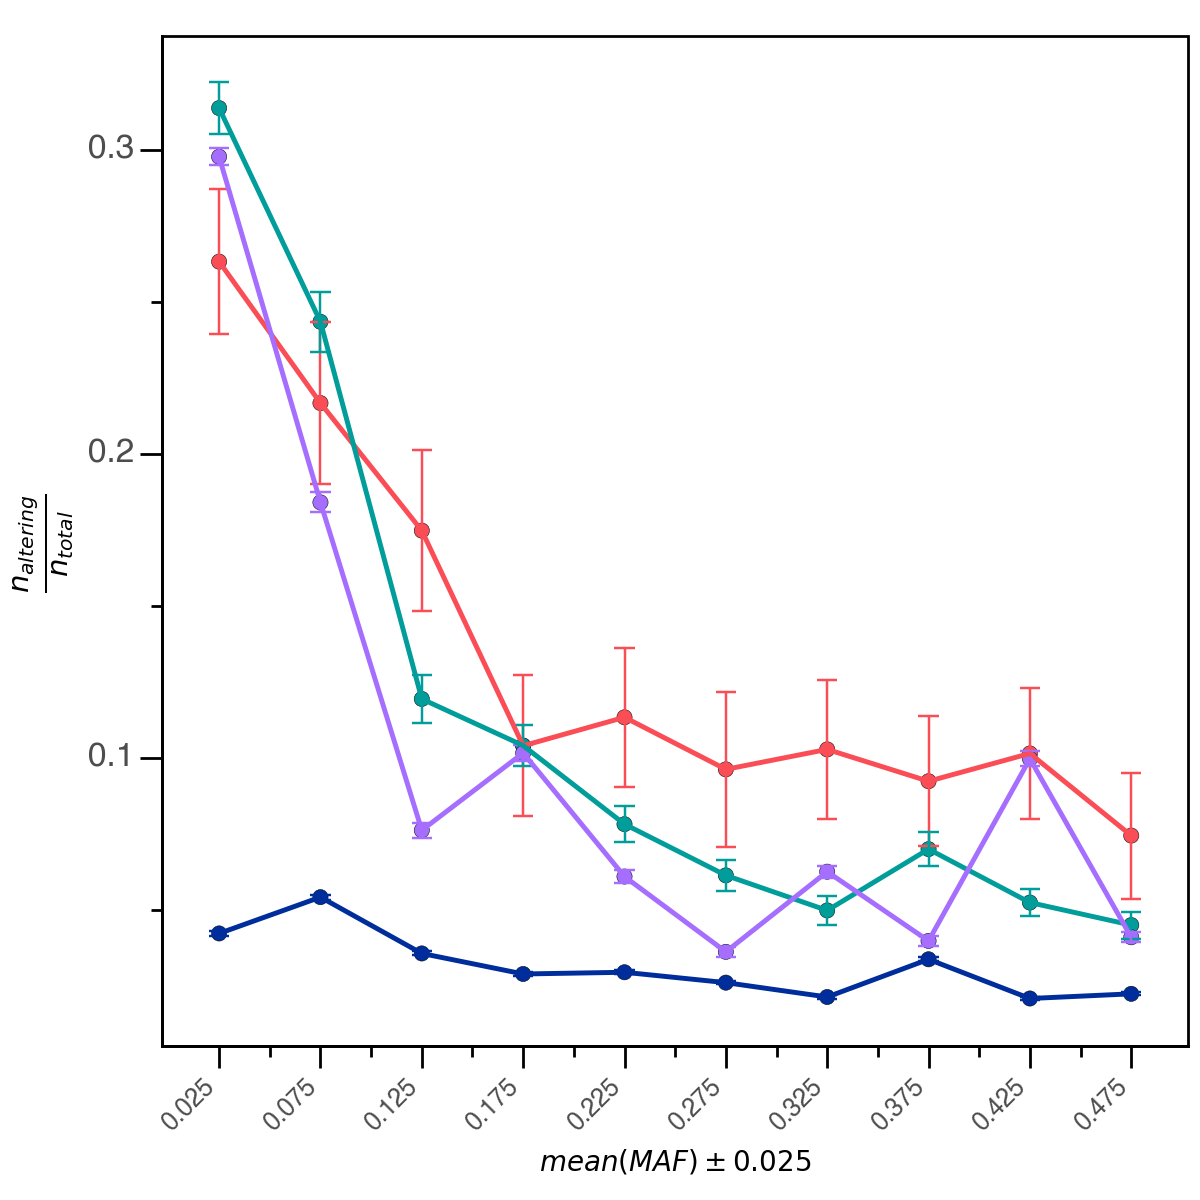

<Figure Size: (600 x 600)>

In [10]:
study_type_totals = data.groupby("studyType")["totalInBucket"].sum()
totals_map = {cat: f"{cat} (N={study_type_totals[cat]:,})" for cat in study_type_totals.index}
data["totals"] = data["studyType"].map(totals_map)
labels = data.drop_duplicates(subset=["studyType", "totals"])
breaks = [x for x in data["midPoint"].unique()]
print(breaks)
plot = (
    pn.ggplot(
        data,
        pn.aes(x="midPoint", y="alteringProportionInBucket", fill="studyType"),
    )
    # + pn.geom_col(position="dodge")
    + pn.geom_point(pn.aes(fill="studyType"), stroke=0.1, size=3)
    + pn.geom_errorbar(
        pn.aes(
            ymin="alteringProportionInBucket - stdErr",
            ymax="alteringProportionInBucket + stdErr",
            x="midPoint",
            color="studyType",
        ),
        width=0.01,
        # position=pn.position_dodge(width=0.9),
    )
    + pn.labs(
        # title="Proportion of lead variant effects in replicated credible sets",
        x=r"$mean(MAF)\pm{0.025}$",
        y=r"$\frac{n_{altering}}{n_{total}}$ ",
        title="",
    )
    + OpenTargetsTheme.categorical_theme(REM=6)
    # Remove the legend
    + pn.theme(axis_title_y=pn.element_text(size=15), axis_title_x=pn.element_text(size=10))
    # + pn.facet_wrap(nrow=3, facets="studyType", scales="free_y")
    + pn.geom_line(
        pn.aes(x="midPoint", y="alteringProportionInBucket", group="studyType", color="studyType"),
        size=1,
    )
    + pn.scale_fill_manual(
        values=OpenTargetsTheme.categorical_dark_colors,
        name="Study Type",
        labels=totals_map,
    )
    + pn.scale_color_manual(
        values=OpenTargetsTheme.categorical_dark_colors,
        name="Study Type",
        labels=totals_map,
    )
    + pn.scale_x_continuous(
        breaks=[x for x in data["midPoint"].unique()],
        labels=[x for x in data["midPoint"].unique()],
    )
    # + pn.theme(legend_position=(0.7, 0.8))
    + pn.theme(legend_position="none", figure_size=(6, 6))
)
plot


## Mean absolute estimated effect size vs MAF bins


[0.025, 0.075, 0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425, 0.475]


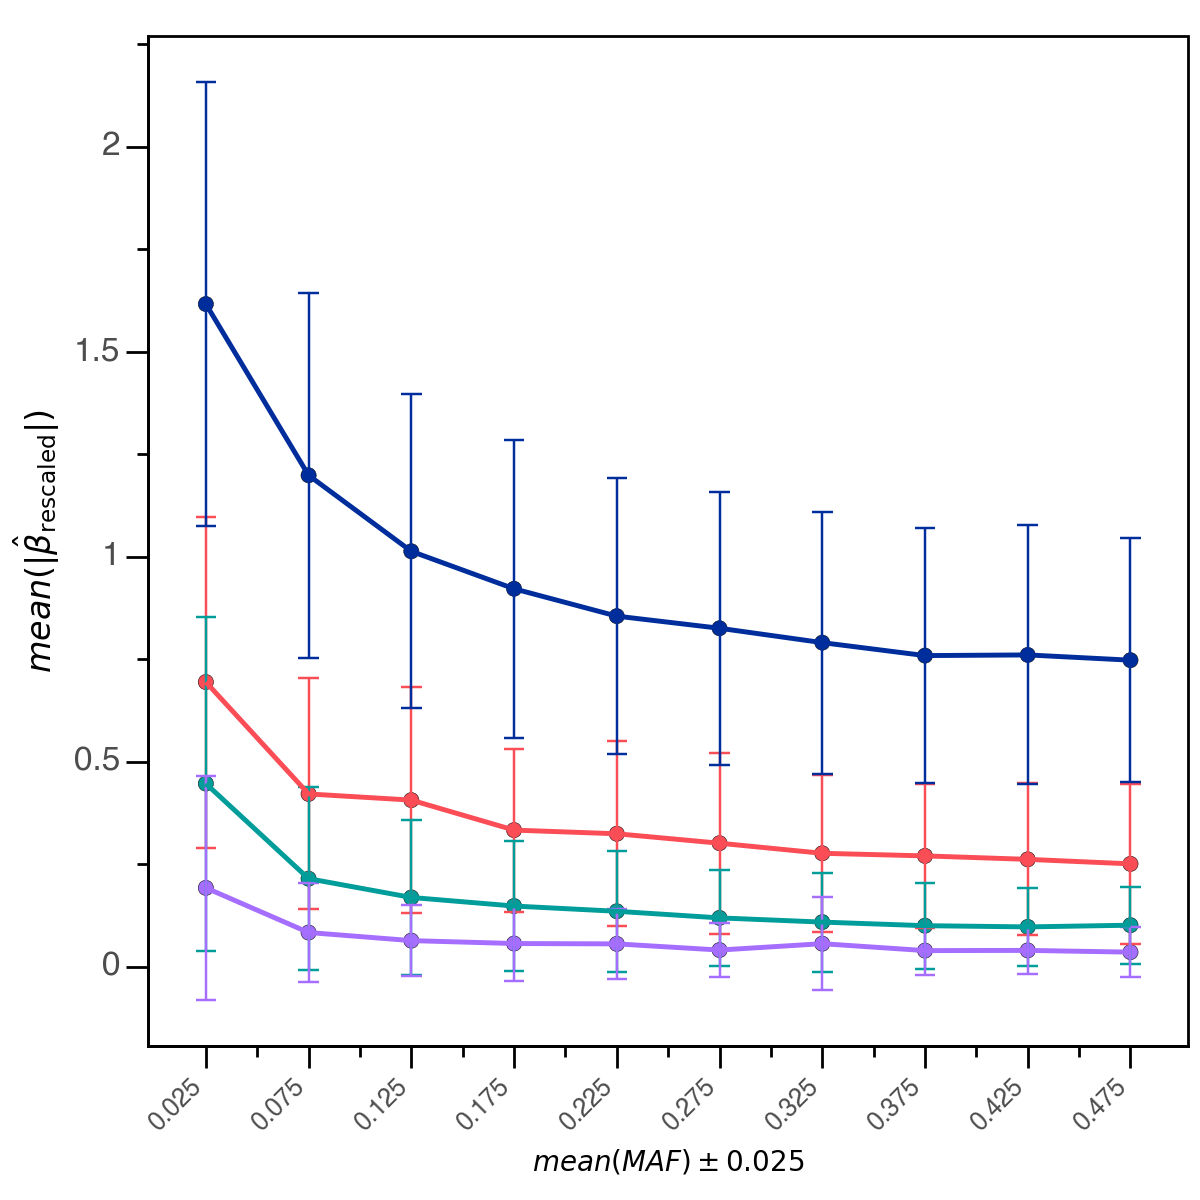

<Figure Size: (600 x 600)>

In [11]:
study_type_totals = data.groupby("studyType")["totalInBucket"].sum()
totals_map = {cat: f"{cat} (N={study_type_totals[cat]:,})" for cat in study_type_totals.index}
data["totals"] = data["studyType"].map(totals_map)
labels = data.drop_duplicates(subset=["studyType", "totals"])
REM = 10
breaks = [x for x in data["midPoint"].unique()]
print(breaks)
plot2 = (
    pn.ggplot(
        data,
        pn.aes(x="midPoint", y="meanAbsEstimatedBeta", fill="studyType"),
    )
    # + pn.geom_col(position="dodge")
    + pn.geom_point(pn.aes(fill="studyType"), stroke=0.1, size=3)
    + pn.geom_errorbar(
        pn.aes(
            ymin="meanAbsEstimatedBeta - stddevAbsEstimatedBeta",
            ymax="meanAbsEstimatedBeta + stddevAbsEstimatedBeta",
            x="midPoint",
            color="studyType",
        ),
        width=0.01,
        # position=pn.position_dodge(width=0.9),
    )
    + pn.labs(
        # title="Proportion of lead variant effects in replicated credible sets",
        x=r"$mean(MAF)\pm{0.025}$",
        y=r"$mean(|\hat{\beta}_{\mathrm{rescaled}}|)$",
    )
    + OpenTargetsTheme.categorical_theme(REM=6)
    + pn.theme(axis_title_x=pn.element_text(size=10))
    # Remove the legend
    # + pn.facet_wrap(nrow=3, facets="studyType", scales="free_y")
    + pn.geom_line(
        pn.aes(x="midPoint", y="meanAbsEstimatedBeta", group="studyType", color="studyType"),
        size=1,
    )
    + pn.scale_fill_manual(
        values=OpenTargetsTheme.categorical_dark_colors,
        name="Study Type",
        labels=totals_map,
    )
    + pn.scale_color_manual(
        values=OpenTargetsTheme.categorical_dark_colors,
        name="Study Type",
        labels=totals_map,
    )
    + pn.scale_x_continuous(
        breaks=[x for x in data["midPoint"].unique()],
        labels=[x for x in data["midPoint"].unique()],
    )
    # + pn.theme(legend_position=(0.70, 0.82))
    + pn.theme(legend_position="none", figure_size=(6, 6))
)
plot2


## Proportion of altering / non altering vs abs(estimatedBeta) bins


In [12]:
PRECISION = 2  # Needs to be the power of 10
PRECISION_FACTOR = len(str(PRECISION)) - 1  # Number of digits in the precision factor
upper_limit = f.ceil(f.col("absEstimatedBeta") * PRECISION) / PRECISION
lower_limit = f.floor(f.col("absEstimatedBeta") * PRECISION) / PRECISION

bucket_dataset = (
    maf_vep_dataset.withColumn("absEstimatedBeta", f.abs("estimatedBeta"))
    .withColumns(
        {
            "minRange": f.when(upper_limit == lower_limit, lower_limit - 1 / PRECISION).otherwise(lower_limit),
            "maxRange": upper_limit,
        }
    )
    .withColumn("midPoint", f.round((f.col("minRange") + f.col("maxRange")) / 2, PRECISION_FACTOR + 2))
    .withColumn("bucket", f.concat(f.col("minRange"), f.lit("-"), f.col("maxRange")))
    .withColumn("vepProportion", calculate_protein_altering_proportion(f.col("consequenceScore")))
    .orderBy("bucket")
    .select(
        "variantId",
        "type",
        "vepProportion.*",
        "consequenceScore",
        "studyType",
        "bucket",
        "absEstimatedBeta",
        "minRange",
        "maxRange",
        "midPoint",
    )
)


In [13]:
data = bucket_dataset.drop_duplicates(["bucket", "studyType"]).toPandas()


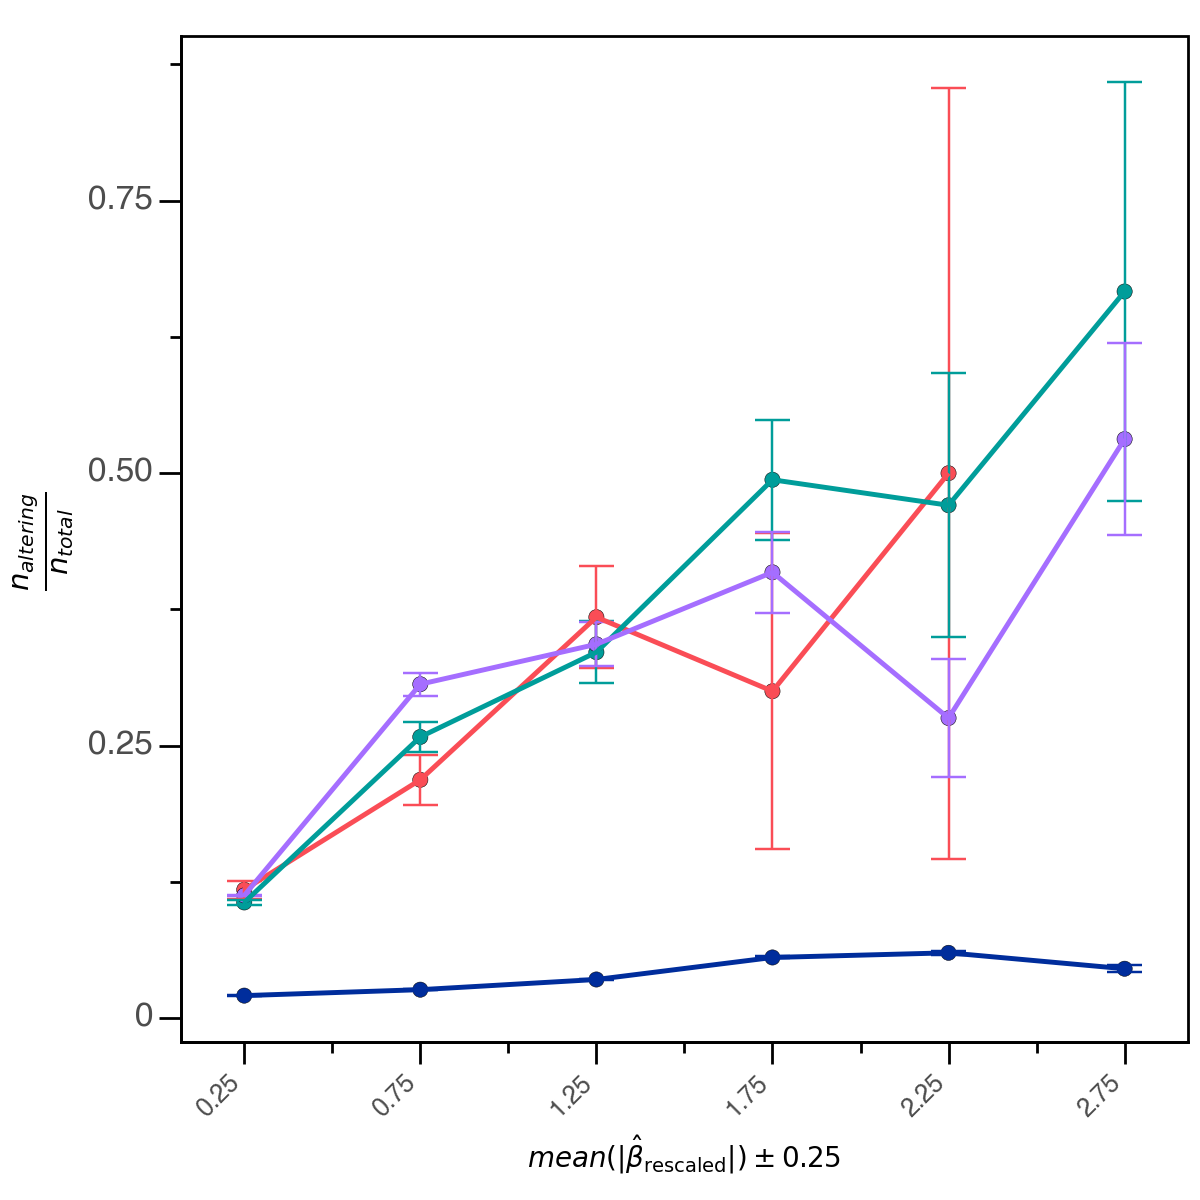

<Figure Size: (600 x 600)>

In [14]:
study_type_totals = data.groupby("studyType")["totalInBucket"].sum()
totals_map = {cat: f"{cat} (N={study_type_totals[cat]:,})" for cat in study_type_totals.index}
data["totals"] = data["studyType"].map(totals_map)
labels = data.drop_duplicates(subset=["studyType", "totals"])
REM = 10

plot3 = (
    pn.ggplot(
        data,
        pn.aes(x="midPoint", y="alteringProportionInBucket", fill="studyType"),
    )
    + pn.geom_point(pn.aes(fill="studyType"), stroke=0.1, size=3)
    + pn.geom_errorbar(
        pn.aes(
            ymin="alteringProportionInBucket - stdErr",
            ymax="alteringProportionInBucket + stdErr",
            x="midPoint",
            color="studyType",
        ),
        width=0.1,
    )
    + pn.labs(
        # title="Proportion of Protein-Altering Variants by Rescaled Effect Size Bucket",
        x=r"$mean(|\hat{\beta}_{\mathrm{rescaled}}|)\pm{0.25}$",
        y=r"$\frac{n_{altering}}{n_{total}}$ ",
    )
    + pn.scale_x_continuous(
        breaks=[x for x in data["midPoint"].unique()],
        labels=[x for x in data["midPoint"].unique()],
    )
    + OpenTargetsTheme.categorical_theme(REM=6)
    # Remove the legend
    # + pn.theme(legend_position="none")
    # + pn.facet_wrap(nrow=3, facets="studyType", scales="free_y")
    + pn.geom_line(pn.aes(x="midPoint", y="alteringProportionInBucket", group="studyType", color="studyType"), size=1)
    + pn.scale_fill_manual(
        values=OpenTargetsTheme.categorical_dark_colors,
        name="Study Type",
        labels=totals_map,
    )
    + pn.scale_color_manual(
        values=OpenTargetsTheme.categorical_dark_colors,
        name="Study Type",
        labels=totals_map,
    )
    + pn.theme(axis_title_x=pn.element_text(size=10), axis_title_y=pn.element_text(size=15))
    # + pn.theme(legend_position=(0.6, 0.8)
    + pn.theme(legend_position="none", figure_size=(6, 6))
)
plot3


## Legend for plots


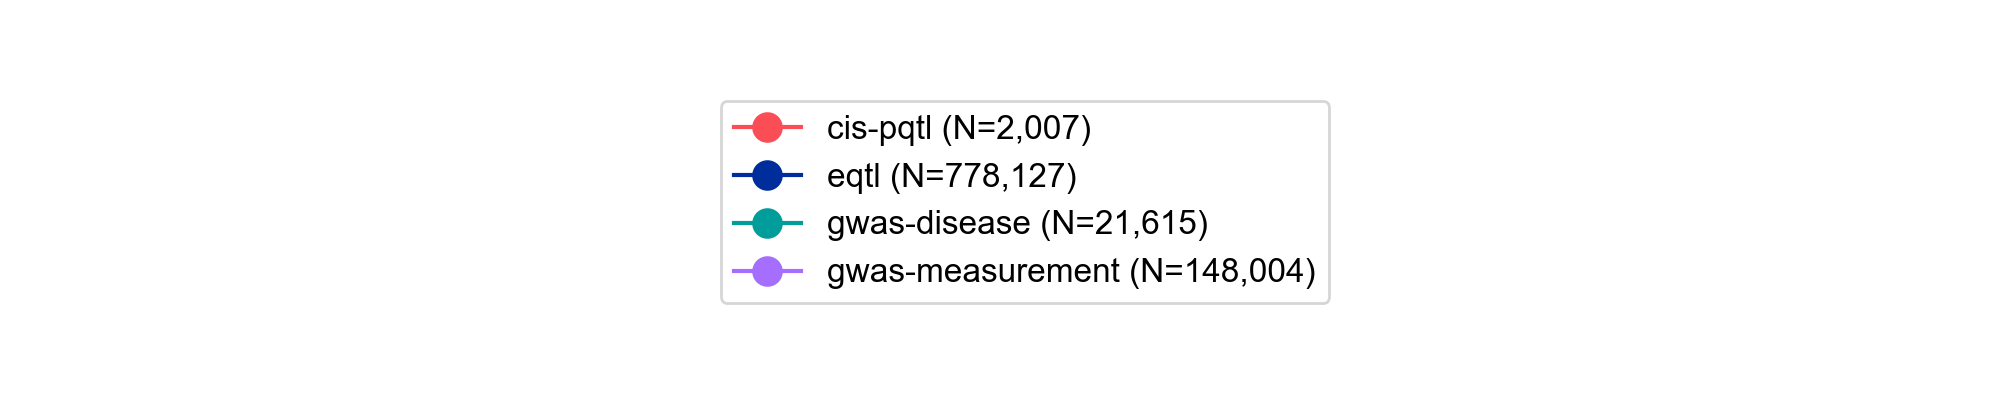

In [15]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(10, 2))
ax = fig.add_subplot(111)

# Create dummy handles (like plot markers or lines) and labels
names = ["cis-pqtl", "eqtl", "gwas-disease", "gwas-measurement"]
colors = OpenTargetsTheme.categorical_dark_colors[: len(names)]
handles = [
    Line2D(
        [0], [0], marker="o", color=color, linestyle="-", label=totals_map[name], markerfacecolor=color, markersize=10
    )
    for name, color in zip(names, colors)
]

labels = [h.get_label() for h in handles]

ax.axis("off")  # Hide the axis

# Add the legend to the axis
legend = ax.legend(handles=handles, labels=labels, loc="center", frameon=True)
fig.show()


## Altering vs non-altering variant counts


In [66]:
gs = group_statistics(
    maf_vep_dataset.withColumn(
        "variantType", f.when(f.col("consequenceScore") >= 0.66, "altering").otherwise("non-altering")
    ),
    [f.col("variantType"), f.col("studyType")],
)
gs.show()
group_data = gs.toPandas()
group_data["label_above"] = group_data.apply(lambda x: "" if x["percentage"] < 70 else f"{x['%']}%", axis=1)
group_data["label_below"] = group_data.apply(lambda x: "" if x["percentage"] >= 70 else f"{x['%']}%", axis=1)
group_data


+------------+----------------+------+-----+-------------------+
| variantType|       studyType| count|    %|         percentage|
+------------+----------------+------+-----+-------------------+
|non-altering|            eqtl|754191|79.41|  79.40917270069166|
|non-altering|gwas-measurement|130765|13.77| 13.768316604422411|
|    altering|            eqtl| 23936| 2.52| 2.5202342082625693|
|non-altering|    gwas-disease| 19054| 2.01| 2.0062058240405665|
|    altering|gwas-measurement| 17239| 1.82| 1.8151035058588918|
|    altering|    gwas-disease|  2561| 0.27|0.26964905612301304|
|non-altering|        cis-pqtl|  1709| 0.18|0.17994152163773108|
|    altering|        cis-pqtl|   298| 0.03|  0.031376578963162|
+------------+----------------+------+-----+-------------------+



,variantType,studyType,count,%,percentage,label_above,label_below
0,non-altering,eqtl,754191,79.41,79.409173,79.41%,
1,non-altering,gwas-measurement,130765,13.77,13.768317,,13.77%
2,altering,eqtl,23936,2.52,2.520234,,2.52%
3,non-altering,gwas-disease,19054,2.01,2.006206,,2.01%
4,altering,gwas-measurement,17239,1.82,1.815104,,1.82%
5,altering,gwas-disease,2561,0.27,0.269649,,0.27%
6,non-altering,cis-pqtl,1709,0.18,0.179942,,0.18%
7,altering,cis-pqtl,298,0.03,0.031377,,0.03%


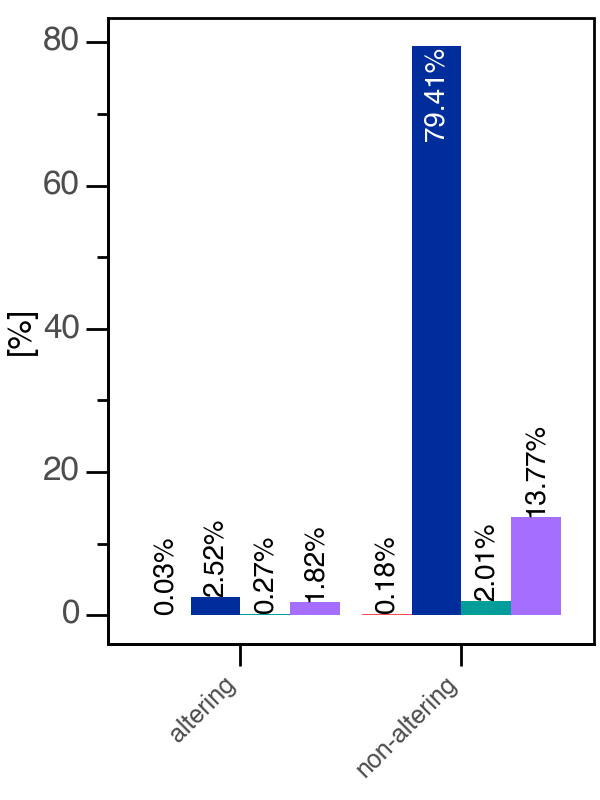

<Figure Size: (300 x 400)>

In [70]:
plot = (
    pn.ggplot(group_data)
    + pn.geom_col(pn.aes(x="variantType", y="percentage", fill="studyType"), position=pn.position_dodge(width=0.9))
    + OpenTargetsTheme.categorical_theme(REM=6)
    + pn.scale_fill_manual(values=OpenTargetsTheme.categorical_dark_colors, name="Study Type", labels=totals_map)
    + pn.geom_text(
        pn.aes(label="label_above", x="variantType", y="percentage", fill="studyType"),
        size=10,
        va="top",
        ha="center",
        color="white",
        position=pn.position_dodge(width=0.9),
        angle=90,
    )
    + pn.geom_text(
        pn.aes(label="label_below", x="variantType", y="percentage", fill="studyType"),
        size=10,
        va="bottom",
        ha="center",
        color="black",
        position=pn.position_dodge(width=0.9),
        angle=90,
    )
    + pn.theme(legend_position="none")
    + pn.labs(x="", y="[%]")
)
plot


+------------+------+-----+-----------------+
| variantType| count|    %|       percentage|
+------------+------+-----+-----------------+
|non-altering|905719|95.36|95.36363665079236|
|    altering| 44034| 4.64|4.636363349207636|
+------------+------+-----+-----------------+



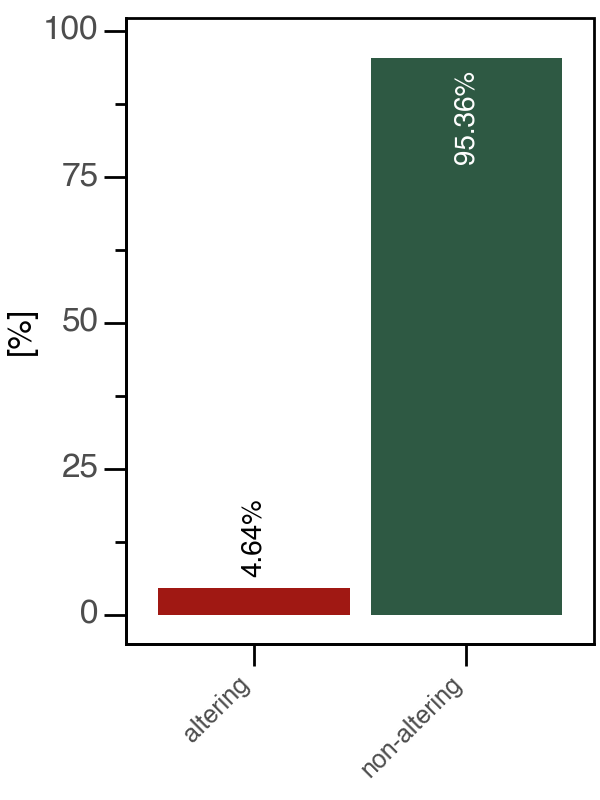

<Figure Size: (300 x 400)>

In [81]:
gs = group_statistics(
    maf_vep_dataset.withColumn(
        "variantType", f.when(f.col("consequenceScore") >= 0.66, "altering").otherwise("non-altering")
    ),
    [f.col("variantType")],
)
gs.show()
group_data = gs.toPandas()
group_data["label_above"] = group_data.apply(lambda x: "" if x["percentage"] < 70 else f"{x['%']}%", axis=1)
group_data["label_below"] = group_data.apply(lambda x: "" if x["percentage"] >= 70 else f"{x['%']}%", axis=1)


plot = (
    pn.ggplot(group_data)
    + pn.geom_col(pn.aes(x="variantType", y="percentage", fill="variantType"))
    + OpenTargetsTheme.categorical_theme(REM=6)
    + pn.scale_fill_manual(
        values=[OpenTargetsTheme.prioritization_colors[0], OpenTargetsTheme.prioritization_colors[-1]],
        name="Study Type",
        labels=totals_map,
    )
    + pn.geom_text(
        pn.aes(label="label_above", x="variantType", y="percentage"),
        size=10,
        va="top",
        ha="center",
        color="white",
        angle=90,
        nudge_y=-2,
    )
    + pn.geom_text(
        pn.aes(label="label_below", x="variantType", y="percentage"),
        size=10,
        va="bottom",
        ha="center",
        color="black",
        angle=90,
        nudge_y=2,
    )
    + pn.theme(legend_position="none")
    + pn.labs(x="", y="[%]")
)
plot


## Group statistics by absolute effect size and groups


In [43]:
gs = (
    maf_vep_dataset.withColumn(
        "variantType", f.when(f.col("consequenceScore") >= 0.66, "altering").otherwise("non-altering")
    )
    .withColumn("absEstimatedBeta", f.abs(f.col("estimatedBeta")))
    .toPandas()
    .groupby(["variantType", "studyType"])
    .agg(
        total=("variantId", "count"),
        min=("absEstimatedBeta", lambda x: x.min()),
        max=("absEstimatedBeta", lambda x: x.max()),
        mean=("absEstimatedBeta", lambda x: x.mean()),
        median=("absEstimatedBeta", lambda x: x.median()),
        stddev=("absEstimatedBeta", lambda x: x.std()),
        q25=("absEstimatedBeta", lambda x: x.quantile(0.25)),
        q75=("absEstimatedBeta", lambda x: x.quantile(0.75)),
    )
    .reset_index()
)


# group_data["label_above"] = group_data.apply(lambda x: "" if x["percentage"] < 70 else f"{x['%']}%", axis=1)
# group_data["label_below"] = group_data.apply(lambda x: "" if x["percentage"] >= 70 else f"{x['%']}%", axis=1)
# group_data


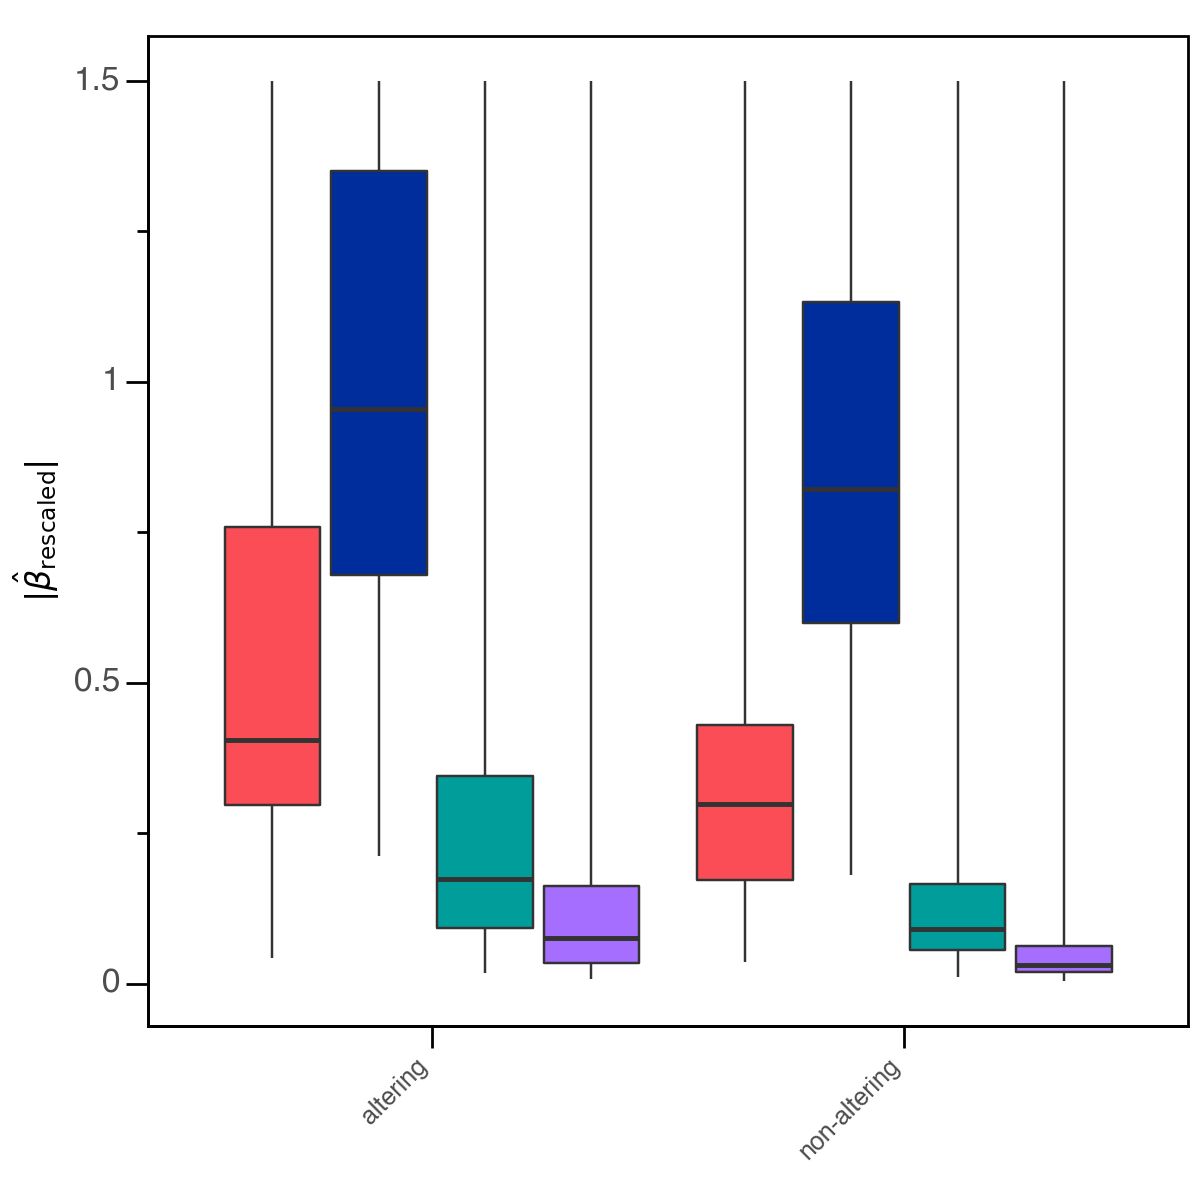

<Figure Size: (600 x 600)>

In [47]:
p = (
    pn.ggplot(gs)
    + pn.geom_boxplot(
        pn.aes(x="variantType", ymin="min", ymax=1.5, middle="median", fill="studyType", upper="q75", lower="q25"),
        stat="identity",
    )
    + OpenTargetsTheme.categorical_theme(REM=6)
    + pn.theme(legend_position="none", figure_size=(6, 6), axis_title_x=pn.element_text(size=10))
    + pn.scale_fill_manual(
        values=OpenTargetsTheme.categorical_dark_colors,
        name="Study Type",
        labels=totals_map,
    )
    + pn.labs(
        x="",
        y=r"$|\hat{\beta}_{\mathrm{rescaled}}|$",
    )
)

p
